### Overview

#### Part 1:

1. Define the Area-of-Interest (AOI):
   * Obtain the outline of Slovenia (provided)
   * Split into manageable smaller tiles
   * Select a small 5x5 area for classification
2. Use the integrated [sentinelhub-py](https://github.com/sentinel-hub/sentinelhub-py) package in order to fill the EOPatches with some content (band data, cloud masks, ...)
   * Define the time interval (this example uses the whole year of 2019)
3. Add additional information from band combinations (norm. vegetation index - NDVI, norm. water index - NDWI)
4. Add a reference map (provided)
   * Convert provided vector data to raster and add it to EOPatches
   
#### Part 2:

5. Prepare the training data
   * Remove too cloudy scenes
   * Perform temporal interpolation (filling gaps and resampling to the same dates)
   * Apply erosion 
   * Random spatial sampling of the EOPatches
   * Split patches for training/validation
6. Construct and train the ML model
   * Make the prediction for each patch 
7. Validate the model
8. Visualise the results

Let's start!

In [92]:
#
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime
import pandas as pd
import folium
import h3
import time
from datetime import timedelta

from pprint import pprint
from rasterio.features import Window
from rasterio.windows import bounds
from shapely.geometry import MultiPolygon, box,Polygon
from PIL import Image
from rasterio.features import Window
from subprocess import call
from IPython import display

# reminder that if you are installing libraries in a Google Colab instance you will be prompted to restart your kernal
import seaborn as sns

import statsmodels.api as sm
from scipy import stats
import plotly.offline as py
import plotly.graph_objs as go

from ipyleaflet import GeoJSON
from geemap import geojson_to_ee, ee_to_geojson,geemap

#Map = geemap.Map()
#ee_data = geojson_to_ee('./data/planet_22.6586,39.256_23.2218,39.4689.geojson')
#Map.addLayer(ee_data, {}, "Volos")

In [42]:
try:
    import geemap, ee
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
    import geemap, ee
    

In [43]:
try:
        geemap.ee_initialize()
except Exception as e:
        geemap.ee_initialize()
        geemap.ee_initialize()



### Define Area of Interest ( VOLOS CASE STUDY)

In [4]:
#this could also be done with a function, but I should provide a list with available names

greece_gdf = gpd.read_file("./data/kontur_boundaries_GR_20220407.gpkg") #read greece geopackage
greece_fc = geemap.geopandas_to_ee(greece_gdf)

# # select shapefile only for volos and make feature collection
# volos_gdf = greece_gdf[greece_gdf['name_en']=='Volos Municipality'] 
# volos_fc = geemap.geopandas_to_ee(volos_gdf) 

# # select shapefles for Trikala Municipality and Trikala Regional Unit shapefile, then
# # make feature collection for trikala municipality and for trikala regional unit
# trikala_mun_gdf = greece_gdf[greece_gdf['name_en']=='Trikala Municipality'] 
# trikala_regunit_gdf = greece_gdf[greece_gdf['name_en']=='Trikala Regional Unit']

# trikala_mun_fc = geemap.geopandas_to_ee(trikala_mun_gdf) 
# trikala_regun_fc = geemap.geopandas_to_ee(trikala_regunit_gdf) #



# Resources : 
https://gis.stackexchange.com/questions/231959/draw-a-grid-of-polygons-in-google-earth-engine

In [337]:
#Read geojsons for volos_municipality

In [44]:
volos_municipality = gpd.read_file("./data/geojson/volos_municipality.geojson")
user= gpd.read_file("./data/geojson/volos_fil.geojson")
volos_1 = gpd.read_file("./data/geojson/volos_1.geojson")
#a = gpd.read_file("./data/geojson/turbo_volos_bldgs.geojson")
volos_municipality

,admin_level,name,name_en,population,hasc,geometry
0,8,Δήμος Βόλου,Volos Municipality,135726.0,None,"MULTIPOLYGON (((22.67119 39.25449, 22.67135 39..."


In [342]:
volos_municipality.bounds

,minx,miny,maxx,maxy
0,22.671186,39.229203,23.105349,39.463396


In [17]:
# read geojson specified by user
user.bounds

,minx,miny,maxx,maxy
0,22.952391,39.358408,22.955158,39.360748


In [19]:
volos_1.bounds

,minx,miny,maxx,maxy
0,408865.378859,4.356907e+06,412487.472094,4.358841e+06


In [14]:
#volos_1['geometry'].values[0].intersect(user['geometry'].values[0])

https://snorfalorpagus.net/blog/2016/03/13/splitting-large-polygons-for-faster-intersections/

The Coordinate Reference System (CRS) is important because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates relate to places on the Earth.

You can find the codes for most commonly used projections from www.spatialreference.org.

The same CRS can often be referred to in many ways. For example, one of the most commonly used CRS is the WGS84 latitude-longitude projection.

In [18]:
# You may need to project the coordinate system. From geodetic coordinates (e.g. 4826) to meters (e.g. 3857) and vice-versa. 
#The calculation of the buffer is usually done in the projected meters system because it takes a distance as an argument.
#The shapely doc may be useful: http://shapely.readthedocs.io/en/latest/manual.html#object.buffer
volos_municipality = volos_municipality.to_crs(epsg=2100) #32634
user = user.to_crs(epsg=2100 )#EPSG:2100 with transformation: 1272
volos_1 = volos_1.to_crs(epsg=2100 )
#volos_municipality = volos_municipality.to_crs(epsg=4087)
#volos_municipality.to_crs('+proj=cea').centroid.to_crs(volos_municipality.crs)

Dimension of the area is 37995 x 26130 m2
Dimension of the area is 261 x 282 m2


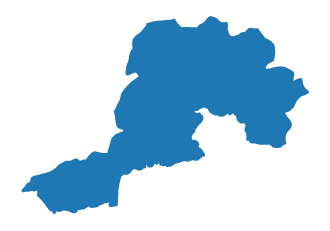

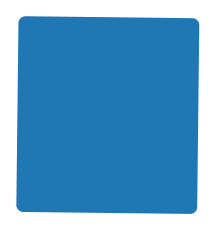

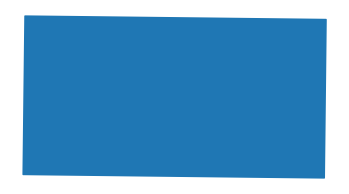

In [21]:
volos_municipality = volos_municipality.to_crs(epsg=2100) #32634
user = user.to_crs(epsg=2100 )#EPSG:2100 with transformation: 1272
volos_1 = volos_1.to_crs(epsg=2100 )

# Add 500m buffer to secure sufficient data near border
volos_municipality_buffered = volos_municipality.buffer(200)
user_buffered = user.buffer(10)
volos_1_buffered = volos_1.buffer(10)
# Get the country's shape in polygon format
volos_municipality_shape = volos_municipality_buffered.geometry.values[0]
user_shape = user_buffered.geometry.values[0]
volos_1_shape = volos_1_buffered.geometry.values[0]
# Plot country
volos_municipality_buffered.plot()
plt.axis("off")
user_buffered.plot()
plt.axis("off")
volos_1_buffered.plot()
plt.axis("off")
## Print size
volos_municipality_width = volos_municipality_shape.bounds[2] - volos_municipality_shape.bounds[0]
volos_municipality_height = volos_municipality_shape.bounds[3] - volos_municipality_shape.bounds[1]
print(f"Dimension of the area is {volos_municipality_width:.0f} x {volos_municipality_height:.0f} m2")
## Print size
user_width = user_shape.bounds[2] - user_shape.bounds[0]
user_height = user_shape.bounds[3] - user_shape.bounds[1]
print(f"Dimension of the area is {user_width:.0f} x {user_height:.0f} m2")

In [450]:
volos_municipality

,admin_level,name,name_en,population,hasc,geometry
0,8,Δήμος Βόλου,Volos Municipality,135726.0,None,"MULTIPOLYGON (((385196.684 4345571.997, 385211..."


In [87]:
#argei arketa na trexei sto timelapse, oso perissotero anevainei h perioxh kai to square size

In [88]:
# https://spatial-dev.guru/2022/05/22/create-fishnet-grid-using-geopandas-and-shapely/
# has other tutorials as well, may prove useful
from shapely import geometry
 
# Create a fishnet
if __name__ == '__main__':
    # Read the shapefile
    gdf = gpd.read_file('./data/geojson/volos_1.geojson')
 
    # Reproject to projected coordinate system
    gdf = gdf.to_crs('EPSG:2100')
 
    # Get the extent of the shapefile
    total_bounds = gdf.total_bounds
 
    # Get minX, minY, maxX, maxY
    minX, minY, maxX, maxY = total_bounds
 
    # Create a fishnet
    x, y = (minX, minY)
    geom_array = []
 
    # Polygon Size
    square_size = 100
    while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size
 
    fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:2100')
    fishnet.to_file('./data/geojson/split/fishnet_grid.geojson')

In [89]:
fishnet = gpd.read_file('./data/geojson/split/fishnet_grid.geojson')
fishnet

,geometry
0,"POLYGON ((408865.379 4356907.001, 408865.379 4..."
1,"POLYGON ((408965.379 4356907.001, 408965.379 4..."
2,"POLYGON ((409065.379 4356907.001, 409065.379 4..."
3,"POLYGON ((409165.379 4356907.001, 409165.379 4..."
4,"POLYGON ((409265.379 4356907.001, 409265.379 4..."
...,...
735,"POLYGON ((412065.379 4358807.001, 412065.379 4..."
736,"POLYGON ((412165.379 4358807.001, 412165.379 4..."
737,"POLYGON ((412265.379 4358807.001, 412265.379 4..."
738,"POLYGON ((412365.379 4358807.001, 412365.379 4..."


In [90]:
#https://eemont.readthedocs.io/en/latest/tutorials/013-Time-Series-By-Region-Pandas.html

### After we split the geojson to smaller equal size polygon-grids we calculate some indices for each of them

In [ ]:
#function that takes desired timeframe through user input ini YY-MM-DD format\n",
def set_dates():
    startDate = input('Enter you desired starting date (YYYYMMDD): ')
    endDate = input('Enter you desired ending date (YYYYMMDD): ')
    return startDate,endDate

startDate,endDate= set_dates()
#('2015-01-01','2022-01-01')

In [ ]:

#magnisia
#"COPERNICUS/S2_SR"
#['EVI','NDVI','NDBI','IBI','UI','BLFEI']

In [ ]:
# Ask the user to define the satellite/image_collection they want to get data for
# Ask him to also define the indices they want to check
gee_name = input()
#indices = input()


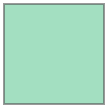

In [126]:
one

In [133]:
fishnet.iloc[1:3]

,geometry
1,"POLYGON ((408965.379 4356907.001, 408965.379 4..."
2,"POLYGON ((409065.379 4356907.001, 409065.379 4..."


In [141]:
geemap.geometry_type(fishnet.loc[1])

TypeError: The ee_object must be one of ee.Geometry, ee.Feature, ee.FeatureCollection.

In [144]:
#fishnet_complete_fc = geemap.geopandas_to_ee(fishnet,geodesic=False)
geemap.geometry_type(fishnet_complete_fc)

'Polygon'

In [140]:
for i in range(len(fishnet)):
    geemap.geojson_to_ee(fishnet['geometry'].loc[i])

Could not convert the geojson to ee.Geometry()


Exception: 'Polygon' object is not subscriptable

In [120]:
for i in fishnet['geometry'].iloc[:2].explode():
    one_fc = ee.FeatureCollection([
       ee.Feature(i,{'pivot':1})
    ])
    
one_fc

EEException: Invalid GeoJSON geometry.

In [ ]:
a=ee.Feature()

In [ ]:
def pivots(geometry):
    for i in fishnet['geometry']:
    pivots = ee.FeatureCollection([
       ee.Feature(i,) i,
    ])

In [ ]:
import eemont #improved iteration of ee api

def select_satellite(gee_name,bounds,indices):
    #data from sentinel-2 surface reflectance

    satellite = (ee.ImageCollection(gee_name)
        .filterBounds(bounds)
        .filterDate(startDate,endDate)
        .maskClouds()
        .scaleAndOffset()
        #.spectralIndices(['EVI','NDVI','NDBI','IBI','UI','BLFEI']))
        .spectralIndices(indices))
    print('satellite data loaded')
    return satellite
#select some bands
#N = s2.select('B8')
#R = s2.select('B4')
#B = s2.select('B2')
#G = s2.select('B3')

s2 = select_satellite(gee_name,magnisia,indices)

In [ ]:
#generate time series over aoi, get spectral indices(awsome index)
def generate_time_series(satellite):
    time_series  = satellite.getTimeSeriesByRegion(ee.Reducer.mean(),
                              geometry = volos_fc,
                              bands = ['NDVI','NDBI','IBI','UI'],
                              scale = 10,
                              bestEffort = True,
                              maxPixels = 1e13,
                              dateFormat = 'YYYYMMdd',
                              tileScale = 2)
    print('start')
    start_time = time.monotonic()

    #use geemap to generate a pandas dataframe from the time series(contains the ts for the selected indices)
    satellite_df= geemap.ee_to_pandas(time_series)
    end_time = time.monotonic()
    print(timedelta(seconds=end_time - start_time))
    
    satellite_df[satellite_df == -9999] = np.nan # we do that to generate nan values when we don't have data
    satellite_df['date'] = pd.to_datetime(satellite_df['date'],infer_datetime_format = True)
    
    return satellite_df


In [51]:
import geemap
Map = geemap.Map()

lat_grid = geemap.latitude_grid(step=5.0, west=-180, east=180, south=-85, north=85)
Map.addLayer(lat_grid, {}, 'Latitude Grid')
lon_grid = geemap.longitude_grid(step=5.0, west=-180, east=180, south=-85, north=85)
Map = geemap.Map()
Map.addLayer(lon_grid, {}, 'Longitude Grid')
grid = geemap.latlon_grid(
    lat_step=10, lon_step=10, west=22.943913, east=22.985708, south=39.359785, north=39.376838
)
Map = geemap.Map()
#df = geemap.ee_to_df(grid)

Map.addLayer(grid, {}, 'Coordinate Grid')
Map

EEException: List.sequence: Sequence size must be >= 0.  Found -8.

# APO DW KAI  KATW EXW KATI DOKIMASTIKA GIA TO SPLITTING

In [146]:
#https://stackoverflow.com/questions/63876018/cut-a-shapely-polygon-into-n-equally-sized-polygons

In [351]:
# Now that we loaded and projected our shapefile, we will proceed to create a grid

In [22]:
## https://gist.github.com/lossyrob/7b620e6d2193cb55fbd0bffacf27f7f2

import os, sys
import argparse
from shapely.geometry import shape, mapping, box
import json

def split_geom(geometry, output_dir, base_name, cols, rows):
    bounds  = geometry.bounds
    xmin = bounds[0]
    xmax =  bounds[2]
    ymin = bounds[1]
    ymax = bounds[3]
    dx = (xmax - xmin) / cols
    dy = (ymax - ymin) / rows
    cut_geoms = {}
    for row in range(0, rows):
        for col in range(0, cols):
            b = box(xmin + (col * dx),
                    ymax - ((row + 1) * dy),
                    xmin + ((col + 1) * dx),
                    ymax - (row * dy))
            g = geometry.intersection(b)
            if not g.is_empty:
                cut_geoms[(col, row)] = g
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for (col, row), geom in cut_geoms.items():
        name = "{}_{}_{}".format(base_name, col, row)
        p = os.path.join(output_dir, "{}.geojson".format(name))
        fc = {}
        fc['type'] = 'FeatureCollection'
        fc['features'] = [{ 'type': 'Feature',
                            'properties': { 'name': name },
                            'geometry': mapping(geom) }]
        with open(p, 'w') as f:
            f.write(json.dumps(fc, indent=4))


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Split up an AOI.')
    parser.add_argument('cols', metavar='COLS', type=int,
                        help='Number of cols in the split grid.')
    parser.add_argument('rows', metavar='ROWS', type=int,
                        help='Number of rows in the split grid.')
    parser.add_argument('input_path', metavar='INPUT_PATH')
    parser.add_argument('output_dir', metavar='OUTPUT_DIR')

    args = parser.parse_args()

    base_name = os.path.splitext(os.path.basename(args.input_path))[0]

    gj = json.loads(open(args.input_path).read())

    features = gj['features']
    if not len(features) == 1:
        print('Feature collection must only contain one feature')
        sys.exit(1)

    geom = shape(features[0]['geometry'])

    split_geom(geom, args.output_dir, base_name, args.cols, args.rows)

usage: ipykernel_launcher.py [-h] COLS ROWS INPUT_PATH OUTPUT_DIR
ipykernel_launcher.py: error: argument COLS: invalid int value: 'C:\\Users\\Christos\\AppData\\Roaming\\jupyter\\runtime\\kernel-7ea5b848-d74a-4e7e-be9b-f57dc7263843.json'
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Christos\anaconda3\envs\ml\lib\argparse.py", line 2476, in _get_value
    result = type_func(arg_string)
ValueError: invalid literal for int() with base 10: 'C:\\Users\\Christos\\AppData\\Roaming\\jupyter\\runtime\\kernel-7ea5b848-d74a-4e7e-be9b-f57dc7263843.json'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Christos\anaconda3\envs\ml\lib\argparse.py", line 1851, in parse_known_args
    namespace, args = self._parse_known_args(args, namespace)
  File "C:\Users\Christos\anaconda3\envs\ml\lib\argparse.py", line 2063, in _parse_known_args
    stop_index = consume_positionals(start_index)
  File "C:\Users\Christos\anaconda3\envs\ml\lib\argparse.py", line 2019, in consume_positionals
    take_action(action, args)
  File "C:\Users\Christos\anaconda3\envs\ml\lib\argparse.py", line 1912, in take_action
    argument_values = self._get_values(action, argument_strings)


TypeError: object of type 'NoneType' has no len()

In [70]:
geemap.get_center(greece, north_up=True, transform=None)

ValueError: The truth value of a GeoSeries is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [383]:
# Auta einai methodoi pou eida gia na kanw to grid, gia kapoio logo de douleuoun

In [110]:
# IMPROVE THE ONE I USE NOW EVENTUALLY WITH THIS RECURSIVE METHOD
#https://snorfalorpagus.net/blog/2016/03/13/splitting-large-polygons-for-faster-intersections/

In [419]:

#gdf = gpd.read_file("./data/geojson/gdf.geojson")
#h3.polyfill(user['geometry']v, 5, geo_json_conformant=False)

In [48]:
# After selecter roi, split it